In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord
import aplpy
from reproject import reproject_interp
from spectral_cube import SpectralCube
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
import astropy.units as u
from astropy.coordinates import Angle, Latitude, Longitude
import math
import scipy.constants
from astropy import units as u

from reproject import reproject_interp

from matplotlib.colors import LogNorm
from astropy.coordinates import match_coordinates_sky
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import interpolate_replace_nans
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LogNorm
import matplotlib.colors
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
#import plotly.graph_objects as go
import skimage.measure as measure

from mpl_toolkits.mplot3d.axes3d import Axes3D

import matplotlib.patheffects as pe
from astropy.visualization import make_lupton_rgb
from astropy.visualization import (MinMaxInterval, PercentileInterval, LogStretch, LinearStretch, ImageNormalize)


In [ ]:
cmz_stone_npbc = "non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz.fits"
hdu_cmzstone_npbc      = fits.open(cmz_stone_npbc)[0]
wcs_cmzstone_npbc = WCS(hdu_cmzstone_npbc.header)

cmz2_stone_npbc = "non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.5GHz.fits"
hdu_cmz2stone_npbc      = fits.open(cmz2_stone_npbc)[0]
wcs_cmz2stone_npbc = WCS(hdu_cmz2stone_npbc.header)

sio_stone_npbc = "non_pb_corrected_from_dan_G0.068-0.075.SiO.217.1GHz.fits"
hdu_siostone_npbc      = fits.open(sio_stone_npbc)[0]
wcs_siostone_npbc = WCS(hdu_siostone_npbc.header)

In [ ]:
h2co = fits.open('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz.fits')
h2co_cube = SpectralCube.read(h2co)
h2co.close()

h2co_5 = fits.open('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.5GHz.fits')
h2co_5_cube = SpectralCube.read(h2co_5)
h2co_5.close()

sio_cmz = fits.open('non_pb_corrected_from_dan_G0.068-0.075.SiO.217.1GHz.fits')
sio_cmz_cube = SpectralCube.read(sio_cmz)
sio_cmz.close()

In [ ]:
h2co_sub_cube = h2co_cube.spectral_slab(30 *u.km / u.s, 74 *u.km / u.s)# 33.1 *u.km / u.s, 68.5 *u.km / u.s
sio_cmz_sub_cube = sio_cmz_cube.spectral_slab(30 *u.km / u.s, 74 *u.km / u.s)
h2co_5_sub_cube = h2co_5_cube.spectral_slab(30 *u.km / u.s, 74 *u.km / u.s)

In [ ]:
h2co_sub_cube.write('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz_slab.fits', format='fits',overwrite=True)
h2co_5_sub_cube.write('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.5GHz_slab.fits', format='fits',overwrite=True)
sio_cmz_sub_cube.write('non_pb_corrected_from_dan_G0.068-0.075.SiO.217.1GHz_slab.fits', format='fits',overwrite=True)

In [2]:
cmz_stone_npbc = "non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz_slab.fits"
hdu_cmzstone_npbc      = fits.open(cmz_stone_npbc)[0]
wcs_cmzstone_npbc = WCS(hdu_cmzstone_npbc.header)

cmz2_stone_npbc = "non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.5GHz_slab.fits"
hdu_cmz2stone_npbc      = fits.open(cmz2_stone_npbc)[0]
wcs_cmz2stone_npbc = WCS(hdu_cmz2stone_npbc.header)

sio_stone_npbc = "non_pb_corrected_from_dan_G0.068-0.075.SiO.217.1GHz_slab.fits"
hdu_siostone_npbc      = fits.open(sio_stone_npbc)[0]
wcs_siostone_npbc = WCS(hdu_siostone_npbc.header)

In [3]:
sio_int = hdu_siostone_npbc.data[0]
h2co5_int = hdu_cmz2stone_npbc.data[0]
h2co_int = hdu_cmzstone_npbc.data[0]
for i in range(1,hdu_siostone_npbc.shape[0]-1,1):
    sio_int = sio_int +hdu_siostone_npbc.data[i]

for i in range(1,hdu_cmz2stone_npbc.shape[0]-1,1):
    h2co5_int = h2co5_int + hdu_cmz2stone_npbc.data[i]

for i in range(1,hdu_cmzstone_npbc.shape[0],1):
    h2co_int = h2co_int + hdu_cmzstone_npbc.data[i]

/var/folders/8n/_rhj_p6j11j3hj9wn3tzy0280000gn/T/ipykernel_40892/319971743.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(111, projection=wcs_cmzstone_npbc.dropaxis(2))


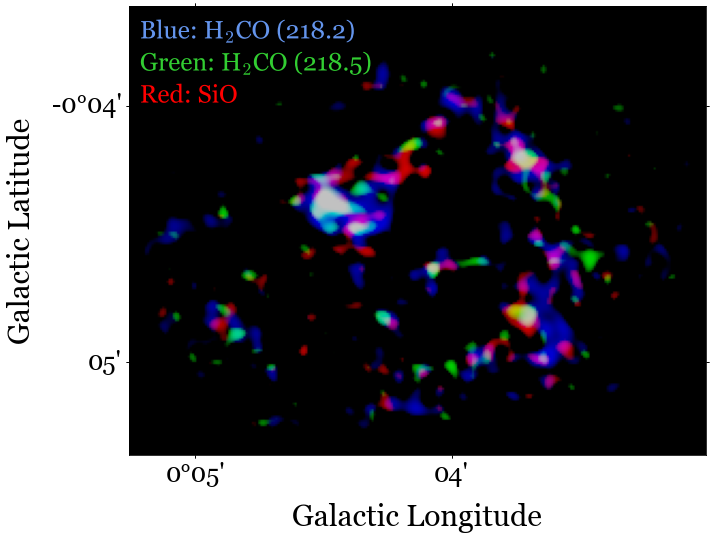

In [54]:

import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = "cm"
mpl.rcParams['font.family'] = "georgia"

### Time to make the figure!
fig, axes = plt.subplots(figsize=(10,10))

### Ok here's the fun part: we need to find a normalization for each color that makes it look
### good. This can be tricky, so try messing around with it for your images.
### Chances are, the default won't be great for you unless you're very lucky.
#b = ImageNormalize(h2co_int,vmin=5, vmax=8, stretch=LogStretch(a=10),clip=True)(h2co_int) # LogStretch(a=50),vmin=0.8
#g = ImageNormalize(h2co5_int,vmin=5, vmax=9, stretch=LogStretch(a=10),clip=True)(h2co5_int) # vmax=3.03
#r = ImageNormalize(sio_int,vmin=5, vmax=10, stretch=LogStretch(a=10),clip=True)(sio_int) # vmax=3.49

b = ImageNormalize(h2co_int,stretch=LogStretch(a=10),vmin=1.6, vmax=5.18, clip=True)(h2co_int) # LogStretch(a=50),vmin=0.8
g = ImageNormalize(h2co5_int,stretch=LogStretch(a=10),vmin=1.6, vmax=3.03, clip=True)(h2co5_int) # vmax=3.03
r = ImageNormalize(sio_int,stretch=LogStretch(a=10),vmin=1.8, vmax=3.49, clip=True)(sio_int) # vmax=3.49

# b = ImageNormalize(region1_f1_hdus[0].data,stretch=LinearStretch(), vmin=0.24, clip=True)(region1_f1_hdus[0].data)
# g = ImageNormalize(region1_f2_hdus[0].data,stretch=LinearStretch(), vmin=0.08, clip=True)(region1_f2_hdus[0].data)
# r = ImageNormalize(region1_f3_hdus[0].data,stretch=LinearStretch(), vmin=0.24, clip=True)(region1_f3_hdus[0].data)

### Now we create the axes object with our correct projection
ax = plt.subplot(111, projection=wcs_cmzstone_npbc.dropaxis(2))
lon = ax.coords[0]
lat = ax.coords[1]
### here's the call to actually make the rgb figure using make_lupton_rgb instead of aplpy
rgb_default = make_lupton_rgb(r, g, b,stretch=1.2,Q=1.0) # minimum=[0.24, 0.08, 0.24]
### Now actually show the grid using imshow
ax.imshow(rgb_default, origin='lower')
### Then label axes
ax.set_xlabel('Galactic Longitude',fontsize=30)
ax.set_ylabel('Galactic Latitude',fontsize=30)
ax.set_xlim(30,300)
ax.set_ylim(40,250)
### Now I add just some nice path effects to make the label text legible
### I suggest changing out the frequency labels for the frequencies of your images
ax.text(s='Blue: H$_{2}$CO (218.2)',x=35,y=235,color='cornflowerblue',
        path_effects=[pe.withStroke(linewidth=2, foreground="black")],
        fontsize=25)
ax.text(s='Green: H$_{2}$CO (218.5)',x=35,y=220,color='limegreen',
        path_effects=[pe.withStroke(linewidth=2, foreground="black")],
        fontsize=25)
ax.text(s='Red: SiO',x=35,y=205,color='red',
        path_effects=[pe.withStroke(linewidth=2, foreground="black")],
        fontsize=25)
lat.set_major_formatter('dd:mm')
lon.set_major_formatter('dd:mm')
lon.set_ticklabel(size=25)
lat.set_ticklabel(size=25)
### why not
plt.tight_layout()

### then save!
# plt.savefig(save_path+"stone_integrated_mar11_24_rgb.pdf", dpi=300, bbox_inches="tight")

In [55]:
fig.savefig('rgb_stone_cloud.pdf',dpi=500)